# How to smooth the velocity field of Elmer/Ice restart files

 - Copyright (c) 2025, Institut des Géosciences de l'Environnement, Grenoble.
 - License: BSD 3-clause "new" or "revised" license (BSD-3-Clause).


In [1]:
import argparse
import numpy as np
from scipy.interpolate import griddata
import xarray as xr
import shapely
import matplotlib.pyplot as plt
from geomodeloutputs.graphics import prepare_fig

In [2]:
## Hard-coded user-defined parameters

restart_file = "restart.nc"

In [3]:
## Other hard-coded parameters

# Names of variables in restart file
varname_vx = "ssavelocity 1"
varname_vy = "ssavelocity 2"

# Expected units
expected_units = {
    varname_vx: "m d-1",
    varname_vy: "m d-1",
}

In [4]:
## Open connections and perform quality checks

ds = xr.open_dataset(restart_file).elmerice
if ds.ntimes != 1:
    raise ValueError("Expecting exactly one time step.")
for varname, units in expected_units.items():
    ds.check_units(varname, units)

In [5]:
## Calculate the velocity

velocity = (ds[varname_vx].values[0, :] ** 2 +
            ds[varname_vy].values[0, :] ** 2) ** 0.5

In [6]:
## Get the triangulation

tri = ds.triangulation

In [7]:
## Function to calculate face values from node values

def node2face(tri, values):
    """Calculate face values from node values."""
    n_nodes = len(tri.x)
    if values.shape != (n_nodes,):
        raise ValueError("Incorrect shape for array of node values.")
    n_faces = tri.triangles.shape[0]
    out = np.full([n_faces], np.nan)
    for i in range(n_faces):
        to_average = [values[j] for j in tri.triangles[i,:]]
        if len(to_average) != 3:
            raise ValueError("This is not a triangle.")
        out[i] = sum(to_average) / len(to_average)
    return out

In [8]:
## Function to smooth face values (for a given cell, average value of this cell and its direct neighbors)

def smooth_face_values(tri, values):
    """Smooth given face values."""
    n_faces = tri.triangles.shape[0]
    if values.shape != (n_faces,):
        raise ValueError("Incorrect shape for array of face values.")
    out = np.full([n_faces], np.nan)
    for i in range(n_faces):
        selected = [i] + [j for j in tri.neighbors[i,:] if j >= 0]
        n_selected = len(selected)
        if n_selected < 3 and n_selected > 4:
            raise ValueError("Bad number of values for the average.")
        to_average = [values[j] for j in selected]
        out[i] = sum(to_average) / len(to_average)
    return out

In [9]:
## Function to interpolate face values onto nodes

def face2nodes(tri, values):
    """Calculate nodes values from face values by interpolation."""
    n_faces = tri.triangles.shape[0]
    if values.shape != (n_faces,):
        raise ValueError("Incorrect shape for array of shape values.")
    # Calculate the coordinates of the centroid of each face
    xy_faces = np.full([n_faces, 2], np.nan)
    for i in range(n_faces):
        coords = [(tri.x[j], tri.y[j]) for j in tri.triangles[i,:]]
        if len(coords) != 3:
            raise ValueError("This is not a triangle.")
        centroid = shapely.Polygon(coords).centroid
        xy_faces[i, 0] = centroid.x
        xy_faces[i, 1] = centroid.y
    xy_nodes = [(tri.x[j], tri.y[j]) for j in range(tri.x.size)]
    return griddata(xy_faces, values, xy_nodes, fill_value=0)

In [10]:
## Smooth velocities a few times

velocity_smoothed = np.array(velocity)

for i in range(3):
    velocity_face = node2face(tri, velocity_smoothed)
    velocity_face_smoothed = smooth_face_values(tri, velocity_face)
    velocity_smoothed = face2nodes(tri, velocity_face_smoothed)

In [11]:
## Graphical parameters

prm_fig = dict(
    lims=[-185798-0.1e5, -185798+0.1e5, -2270857-0.1e5, -2270857+0.1e5],
    crs="greenland",
    coastlines=dict(lw=0.5),
)

prm_plot = dict(vmin=min(velocity.min(), velocity_smoothed.min()),
                vmax=max(velocity.max(), velocity_smoothed.max()))

if prm_plot["vmin"] < 0:
    raise ValueError("There are negative velocities.")

units = ds.units_mpl(varname_vx)

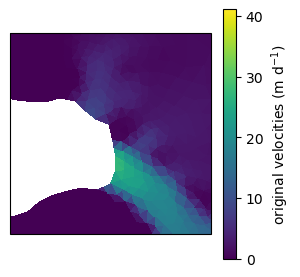

In [12]:
## Plot the original velocities

prepare_fig(**prm_fig)
plot = plt.tripcolor(tri, velocity, **prm_plot)
cb = plt.colorbar(plot, label="original velocities (%s)" % units)

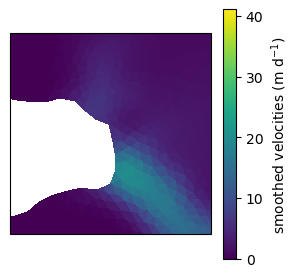

In [13]:
## Plot the smoothed velocities

prepare_fig(**prm_fig)
plot = plt.tripcolor(tri, velocity_smoothed, **prm_plot)
cb = plt.colorbar(plot, label="smoothed velocities (%s)" % units)

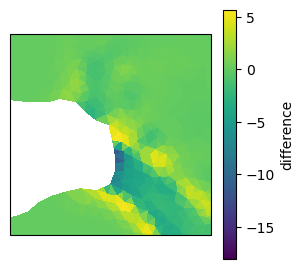

In [14]:
## Plot the difference

prepare_fig(**prm_fig)
plot = plt.tripcolor(tri, velocity_smoothed - velocity)
cb = plt.colorbar(plot, label="difference")

In [15]:
## Close connections

ds.close()